In [221]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [222]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [223]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [224]:
import numpy as np
import pandas as pd
import torch
from torch import nn
# from d2l import torch as d2l

In [225]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [226]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [227]:
from torch.utils.data import Dataset, DataLoader
# 将传入的数据集转换为Dataset类
class DataSet(Dataset):
    def __init__(self,data,features=None):
        self.data=data
        self.features=features
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.features is not None:
            return self.data[idx],self.features[idx]
        return self.data[idx]

In [228]:
print(train_data.shape)

(1460, 81)


In [229]:
#让我们看看前四个和最后两个特征，以及相应标签（房价）的前四个样本
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [230]:
#提取特征和标签
# features=train_data.columns[1:-1].tolist()
# labels=train_data.iloc[:,-1].tolist()
# features,len(labels)
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index #数值特征
# 标准化数值特征，
# 对于每一列（x），它首先计算该列的均值（x.mean()），然后计算该列的标准差（x.std()）。
# 然后，它从每个元素中减去均值，并除以标准差。这个过程对列中的每个元素都会执行。
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
numeric_features,all_features.shape

(Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold'],
       dtype='object'),
 (2919, 79))

In [231]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
# 由于`all_features`的数据类型是`pandas`，转换为`numpy`格式供后面的训练使用，但是必须要数值列，所以需要将非数值列转换为数值列
all_features = all_features.astype('float32') # 实则就是将ture /false 转换为 1 / 0
all_features[:5].values

array([[ 0.06731988, -0.18444261, -0.21784137, ...,  1.        ,
         0.        ,  0.        ],
       [-0.8734664 ,  0.45809588, -0.07203174, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.06731988, -0.05593492,  0.13717337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.30251643, -0.39862213, -0.07837129, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06731988,  0.6294395 ,  0.5188142 , ...,  1.        ,
         0.        ,  0.        ]], dtype=float32)

In [232]:
n_train = train_data.shape[0] #训练数据集的样本数
# 训练样本
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
# 测试样本
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# 训练标签
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [233]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
# class Net(nn.Module):  # 我们建立的CNN继承nn.Module这个模块
#     def __init__(self,input_size,hidden_size,output_size):
#         super(Net, self).__init__()
#         self.hidden=nn.Linear(input_size,hidden_size)
#         self.out=nn.Linear(hidden_size,output_size)
#         
# 
#     # 下面定义x的传播路线
#     def forward(self, x):
#         x = self.hidden(x)  # x先通过hidden
#         x=nn.ReLU(x)
#         output = self.out(x)  # 再通过out
#         return output
#     
# def get_net():
#     net = nn.Sequential(
#         nn.Linear(in_features,256),
#         nn.Linear(256,256),
#         
#     )
#     return net

In [234]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [235]:
from tqdm import tqdm
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_set= DataSet(train_features, train_labels)
    test_set = DataSet(test_features, test_labels)
    train_iter = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_iter = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in tqdm(range(num_epochs),desc='Training',leave=True):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
        if epoch%100==0:
            print(f"Current epoch {epoch/100}Train_ls:{train_ls[-1]:.4f}")
    return train_ls, test_ls

In [245]:
from matplotlib import pyplot as plt
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size,hidden_size):
    net = nn.Sequential(nn.Linear(in_features, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 1))
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plt.plot(np.arange(1, num_epochs + 1), train_ls)
    plt.xlabel('epoch')
    plt.ylabel('rmse')
    plt.show()
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Training:   1%|          | 6/1000 [00:00<00:38, 25.80it/s]

Current epoch 0.0Train_ls:0.4865


Training:  10%|█         | 104/1000 [00:05<00:56, 15.75it/s]

Current epoch 1.0Train_ls:0.0795


Training:  20%|██        | 202/1000 [00:12<00:54, 14.56it/s]

Current epoch 2.0Train_ls:0.0480


Training:  30%|███       | 304/1000 [00:18<00:46, 14.98it/s]

Current epoch 3.0Train_ls:0.0738


Training:  40%|████      | 402/1000 [00:26<00:51, 11.51it/s]

Current epoch 4.0Train_ls:0.0517


Training:  50%|█████     | 502/1000 [00:33<00:34, 14.26it/s]

Current epoch 5.0Train_ls:0.0571


Training:  60%|██████    | 602/1000 [00:42<00:30, 12.88it/s]

Current epoch 6.0Train_ls:0.0503


Training:  70%|███████   | 703/1000 [00:53<00:23, 12.71it/s]

Current epoch 7.0Train_ls:0.0490


Training:  80%|████████  | 803/1000 [01:00<00:12, 15.81it/s]

Current epoch 8.0Train_ls:0.0546


Training:  90%|█████████ | 903/1000 [01:06<00:06, 16.12it/s]

Current epoch 9.0Train_ls:0.0737


Training: 100%|██████████| 1000/1000 [01:12<00:00, 13.77it/s]


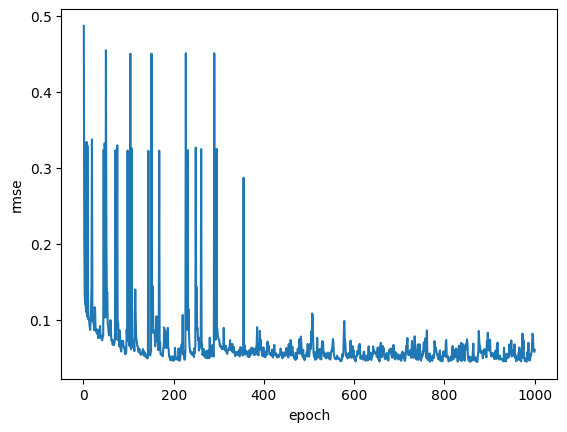

训练log rmse：0.060462


In [248]:
k, num_epochs, lr, weight_decay, batch_size,hidden_size = 5, 1000, 5, 0, 64,256
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size,hidden_size)